In [144]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier  
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [145]:
data = pd.read_csv("Smalldf.csv")

In [146]:
del data["Unnamed: 0"]

### т.к. в датасете не оказалось тестовых данных мы сделаем свои зашумленные данные. Я решил сделать 100 тестовых данных которые зашумлены на 25%

In [147]:
np.random.RandomState(42)

In [148]:
len_W = data["W_without_stopwords"].apply(lambda x: len(x.split(" ")))

In [149]:
tmp={"T":[],"W":[]}
for _ in range(100):
    first,second = np.random.randint(0,88),np.random.randint(0,88)
    left = data["W_without_stopwords"].iloc[first].split(" ")[len_W[second]*1//4:]
    right = data["W_without_stopwords"].iloc[second].split(" ")[:len_W[second]*1//4]
    target = data["T"].iloc[first]
    full = " ".join(left + right)
    tmp["T"].append(target)
    tmp["W"].append(full)

In [150]:
test = pd.DataFrame(data=tmp)

In [151]:
test.head(3)

,T,W
0,сантехника и отопление,объектах осуществляет планирование проектирова...
1,сервис на воздушном транспорте,безопасности агент регистрации конкурсе возмож...
2,парикмахерское искусство,данного направления постоянно развивается явля...


## подготовка тестовой и тренировочной выборки

In [152]:
X_test = test["W"]
y_test = test["T"]

In [153]:
vectorizer = CountVectorizer()
X_test_counts = vectorizer.fit_transform(X_test)
transformer = TfidfTransformer()
X_test_tfidf = transformer.fit_transform(X_test_counts)

In [154]:
X_test_counts.shape

(100, 5568)

In [155]:
X_train = data["W_without_stopwords"]

In [156]:
y_train = data["T"]

In [157]:
vectorizer = CountVectorizer()

In [158]:
X_train_counts = vectorizer.fit_transform(X_train)

In [159]:
X_train_counts.shape

(88, 6983)

In [160]:
transformer = TfidfTransformer()
X_train_tfidf = transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(88, 6983)

## Классификаторы 

In [161]:
models = [
        SGDClassifier(),
        MultinomialNB(),
        RandomForestClassifier(),
        SVC(),
        DecisionTreeClassifier()
        ]

#### использую pipeline 

In [162]:
TestModels = pd.DataFrame()
temp = {}
for model in models:
    m = str(model)
    print(m)
    temp['Model'] = m[:m.index('(')]
    
    text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', model),
    ])
    
    text_clf = text_clf.fit(X_train, y_train)
    pred = text_clf.predict(X_test)
    
    temp['accuracy_score'] = accuracy_score(pred, y_test)
    print('accuracy_score', accuracy_score(pred, y_test))
    TestModels = TestModels.append([temp])
TestModels.set_index('Model', inplace=True)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
accuracy_score 0.84
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
accuracy_score 0.42
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, w

## Как видно из графика случайный лес и градиент показали себя лучше всего 

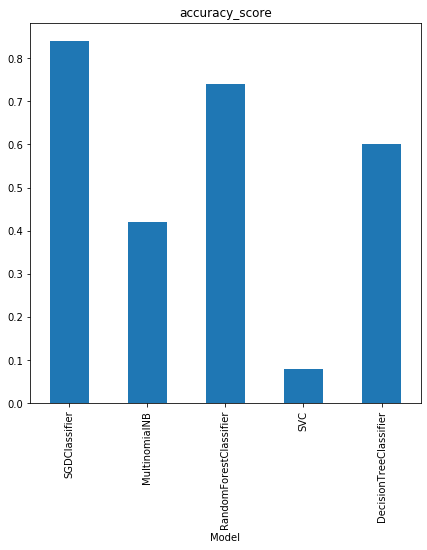

In [163]:
fig, axes = plt.subplots(ncols=1, figsize=(7, 7))
TestModels.accuracy_score.plot(ax=axes, kind='bar', title='accuracy_score')
plt.show()

## Подбор гиперпараметров

In [164]:
TMP={"n_estimators":[],"max_depth":[],"accuracy_score":[]}

param_rand_f = {
    'n_estimators'      : [10,50,100,150,200],
    'max_depth'         : [8, 9, 10, 11, 12],
}


for n_e in param_rand_f["n_estimators"]:
    for m_d in param_rand_f["max_depth"]:
        clf = RandomForestClassifier(n_estimators=n_e, max_depth=m_d)
        text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', clf),
        ])
    
        text_clf = text_clf.fit(X_train, y_train)
        pred = text_clf.predict(X_test)
    
#         print('accuracy_score', accuracy_score(pred, y_test),"n_estimators",n_e,"max_depth",m_d, sep=" ")
        TMP["n_estimators"].append(n_e)
        TMP["max_depth"].append(m_d)
        TMP["accuracy_score"].append(accuracy_score(pred, y_test))


In [165]:
ScoreRFC = pd.DataFrame(data=TMP)
ScoreRFC[ScoreRFC["accuracy_score"] == ScoreRFC["accuracy_score"].max()]

,n_estimators,max_depth,accuracy_score
21,200,9,0.88
23,200,11,0.88


In [166]:
param_SGD = {
    'loss': ['hinge','log'],
    'penalty': ['l1','l2'],
    'alpha': [10 ** x for x in range(-6, 1)],
    'l1_ratio': [0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95],
}

TMP={"loss":[],"penalty":[],"l1_ratio":[],"alpha":[],"accuracy_score":[]}

for L in param_SGD["loss"]:
    for P in param_SGD["penalty"]:
        for l1_r in param_SGD["l1_ratio"]:
            for A in param_SGD["alpha"]:
                clf = SGDClassifier(loss=L, penalty=P, l1_ratio=l1_r, alpha=A)
                text_clf = Pipeline([('vect', CountVectorizer()),
                              ('tfidf', TfidfTransformer()),
                              ('clf', clf),
                ])

                text_clf = text_clf.fit(X_train, y_train)
                pred = text_clf.predict(X_test)

                TMP["loss"].append(L)
                TMP["penalty"].append(P)
                TMP["l1_ratio"].append(l1_r)
                TMP["alpha"].append(A)
                TMP["accuracy_score"].append(accuracy_score(pred, y_test))
ScoreSGD = pd.DataFrame(data=TMP)

                
#                 print('accuracy_score', accuracy_score(pred, y_test),
#                       "loss", L,
#                       "penalty", P,
#                       "l1_ratio", l1_r,
#                       "alpha", A,
#                       sep=" ")


In [167]:
ScoreSGD[ScoreSGD["accuracy_score"] == ScoreSGD["accuracy_score"].max()]

,loss,penalty,l1_ratio,alpha,accuracy_score
66,hinge,l2,0.2,0.001,0.88


In [2]:
import pandas as pd
df = pd.read_csv("C:\\Users\\User\\Desktop\\final_C1\\Fulldf.csv")

In [6]:
df

,Unnamed: 0,0,ALL_W
0,0,Разработка компьютерных игр и мультимедийных п...,разработка компьютерных игр и мультимеди...
1,1,Разработка мобильных приложений(юниоры),разработка компьютерных игр и мультимеди...
2,2,Преподавание в младших классах,разработка компьютерных игр и мультимеди...
3,3,Дошкольное воспитание(юниоры),разработка компьютерных игр и мультимеди...
4,4,Дошкольное воспитание,разработка компьютерных игр и мультимеди...
...,...,...,...
125,125,Электромонтаж,0 Разработка компьютерных игр и мультимед...
126,126,Электромонтаж (Юниоры),0 Разработка компьютерных игр и мультимед...
127,127,Эстетическая косметология,0 Разработка компьютерных игр и мультимед...
128,128,Эстетическая косметология (Юниоры),0 Разработка компьютерных игр и мультимед...


In [5]:
df["0"].value_counts()

Печатные технологии в прессе                               2
Печатные технологии в прессе (Юниоры)                      1
Разработка решений на базе блокчейн технологи              1
ИТ-решения для бизнеса  на платформе «1С:Предприятие 8»    1
Парикмахерское искусство                                   1
                                                          ..
Кузовной ремонт (Юниоры)                                   1
Управление фронтальным погрузчиком                         1
Хлебопечение                                               1
Ландшафтный дизайн                                         1
Дошкольное воспитание                                      1
Name: 0, Length: 129, dtype: int64